# План

_Основное_:
- Эффективное логирование
- Loggers
- HOOKS - Перенести в Lightning Intro

_Torchmetrics_:
- Функциональный вызов
- Класс и кумулятивные вычисления


_Tuner_:
- Автоматическое нахождение learning_rate
- Автоматическое нахождение batch_size

<image src="../images/pl.webp" alt="Trainer" height=500>


Ссылка на доки Torchmetrics https://torchmetrics.readthedocs.io/en/v1.3.0/

# Зачем нужен Trainer?



Тренер в реальной жизни тренирует вас, давая обратную связь о ваших успехах, делая отчеты о прогрессе, помогая вам допиться результатов. `Trainer` из `Lightning` делает то же с вашей моделью:
- Сам ее обучает, используя `EarlyStopping` и др.
- Собирает метрики по мере обучения
- Хотите обучать нейронку на GPU? А если GPU несколько - не проблема, можно запустить обучение хоть на 100 GPU

# Его фишки

- Больше не нужно писать огромные train loop для обучения вашей нейронки. Надо добавить `EarlyStopping` - добавляем в `Trainer` и ликуем
- Использование любого логера. Если вы используете `W&B` или `CometML` и прочие, то это не проблема. В процессе обучения логируем метрики, а `Trainer` сам отправит на сервер
- Распределенное обучение. Если у вас есть несколько GPU, то есть возможность ускорить обучение
- Простота. Теперь, чтобы внести какую-то фишку в процесс обучения не надо ее писать с 0, так как уже все готов в `Lightning` - берем и пользуемся! 

# Настраиваемся на работу

In [1]:
import copy
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split

from lightning import Trainer, LightningModule, LightningDataModule
from lightning.pytorch.callbacks import ModelSummary
import lightning.pytorch as pl

from typing import Tuple

## Конфиг

In [2]:
@dataclass
class CFG:
    model_name: str = 'Lightning ⚡️ Improved'
    seed: int = 2024
    device: str = "cuda"  # 'cpu'
    device_count: int = 1
    hidden_size: int = 128
    dropout: float = 0.1
    lr: float = 1e-3
    batch_size: int = 128
    num_workers: int = 4
    epochs: int = 20
    gpus: int = 2
cfg = CFG()

### Фиксируем seed

In [3]:
from lightning.pytorch import seed_everything

seed_everything(cfg.seed)

Seed set to 2024


2024

# 🤹 Подгружаем dataset

In [4]:
rides_info = pd.read_csv('https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/quickstart_train.csv')
rides_info.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


In [5]:
# Проводим препроцессинг данных для старта обучения
drop_cols = ["car_id", "target_reg", "target_class"]
cat_cols = ["car_type", "fuel_type", "model"]
rides_info = pd.get_dummies(rides_info, columns=cat_cols)
rides_info.fillna(rides_info.median(numeric_only=True), inplace=True)
num_cols = [col for col in list(rides_info.columns) if col not in drop_cols]

In [6]:
# нормализуем данные и кодируем таргет

scaler = RobustScaler()
le = LabelEncoder()

df = scaler.fit_transform(rides_info[num_cols])
df = pd.DataFrame(df, columns=num_cols)

target_scaler = RobustScaler()
target = target_scaler.fit_transform(rides_info["target_reg"].values.reshape(-1, 1))

df["target_reg"] = target
df["target_class"] = le.fit_transform(rides_info["target_class"]).reshape((-1, 1))

In [7]:
# Разбиваем датасет на трэйн и тест выборки
train, test = train_test_split(df, test_size=0.2, random_state=cfg.seed)

cfg.num_features = train.shape[1] - 2  # количество фичей, подаваемое на вход
cfg.num_tar_class = (
    train.target_class.nunique()
)  # количество выходов равно количеству предсказываемых классов

In [8]:
df.head(3)

,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,...,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4,target_reg,target_class
0,-0.460317,0.5,0.258414,0.75,0.567305,-0.187985,0.0,0.129562,0.019027,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.022894,0
1,-0.365079,0.5,0.303616,0.75,0.072227,0.841243,-0.1,0.237381,1.085987,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.238877,2
2,1.539683,-1.0,-0.903502,-0.25,0.626258,0.465096,0.0,-1.077932,0.235335,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219438,7


# Dataset

In [9]:
# датасет выдает фичи и значения целевых переменных
class Rides(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx, :]

        data = row.drop(labels=["target_reg", "target_class"])
        data = torch.FloatTensor(data.values.astype("float"))
        tar_reg = torch.tensor(row["target_reg"]).float()
        tar_class = row["target_class"].astype("int")

        return data, tar_reg, tar_class

In [10]:
train_datasets = {"train": Rides(train), "val": Rides(test)}

In [74]:
class RidesLightning(LightningDataModule):
    def __init__(self, cfg: CFG, train_datasets: dict) -> None: 
        # Сохраняем переменные для дальнейшей работы
        super().__init__()

        self.cfg = cfg
        self.datasets = train_datasets
        self.batch_size = self.cfg.batch_size

    def setup(self, stage: str):
        # Создаем Dataset'ы
        self.train = self.datasets["train"]
        self.val = self.datasets["val"]

    
    def _make_dataloader(self, dataset, cfg):
        # Общий метод для создания DataLoader
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.cfg.num_workers,
            pin_memory=True
        )

    def train_dataloader(self):
        # Возвращаем Train Dataloader
        return self._make_dataloader(self.train, cfg)
    
    def val_dataloader(self):
        # Возвращаем Valid Dataset
        return self._make_dataloader(self.val, cfg)
    
    def teardown(self, stage: str):
        # Функция, которая выполняется после создания Dataloader - здесь можно удалить ненужные компоненты
        del self.train, self.val

In [75]:
dataset = RidesLightning(cfg, train_datasets)

In [76]:
class LightningModel(LightningModule):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.lr = cfg.lr # ВАЖНО! Сохраняйте lr в модели

        self.mlp = nn.Sequential(
            nn.Linear(cfg.num_features, cfg.hidden_size),
            # nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.LeakyReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            # nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.GELU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size // 2),
        )
        # Так как два таргета, делаем две головы - одна для регрессии, другая - классификации
        self.regressor = nn.Sequential(nn.Linear(cfg.hidden_size // 2, 1))
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, cfg.num_tar_class)
        )
        
        self.regressor = nn.Sequential(nn.Linear(cfg.hidden_size // 2, 1))

        self.regression_criterion = nn.MSELoss()
        self.classification_criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # Forward pass through the network
        x = self.mlp(x)
        tar_reg = self.regressor(x)
        tar_class = self.classifier(x)
        return tar_reg.view(-1), tar_class
    
    def basic_step(self, batch, batch_idx, step: str):
        # Получаем данные
        data, reg_target, clas_target = batch

        pred_reg, pred_clas = self(data)

        loss_reg = self.regression_criterion(pred_reg, reg_target)
        loss_class = self.classification_criterion(pred_clas, clas_target)
        loss = loss_reg + loss_class

        return {
            f"{step}/loss": loss,
            f"{step}/reg_loss": loss_reg,
            f"{step}/reg_class": loss_class
        }
    
    def training_step(self, batch, batch_idx):
        loss_dict = self.basic_step(batch, batch_idx, "train")
        
        # Сохраняем метрики
        self.log_dict(loss_dict)
        
        return loss_dict["train/loss"]
    
    def validation_step(self, batch, batch_idx):
        loss_dict = self.basic_step(batch, batch_idx, "valid")
        
        # Сохраняем метрики
        self.log_dict(loss_dict)
        
        return loss_dict["valid/loss"]
    
    
    def test_step(self, batch, batch_idx):
        loss_dict = self.basic_step(batch, batch_idx, "test")
        
        # Сохраняем метрики
        self.log_dict(loss_dict)
        
        return loss_dict["test/loss"]
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.05)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.cfg.epochs)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train/loss",
                "interval": "epoch",
                "reduce_on_plateau": True,
            }
        }

In [77]:
model = LightningModel(cfg)
model

LightningModel(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=9, bias=True)
  )
  (regression_criterion): MSELoss()
  (classification_criterion): CrossEntropyLoss()
)

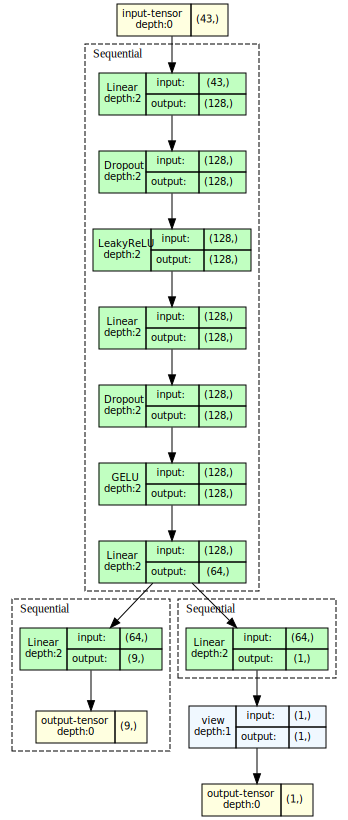

In [78]:
# Посмотрим какая модель у нас получилась
from torchview import draw_graph

model_graph = draw_graph(model, input_size=[cfg.num_features], expand_nested=True)
model_graph.visual_graph

# Trainer

<div class="alert alert-info">

Основные параметры `Trainer`:
* `accelerator` - если вы хотите тренировать модель на `cpu`, `gpu` или же `tpu`, `hpu` и прочих устройствах
* `devices` - кол-во `cpu`, `gpu`. Можно поставить `-1` - будут использоваться все ресурсы
* `logger` - Логгер обучения модели. Можно использовать: `WandbLogger`, `MLFlowLogger`, `NeptuneLogger` и прочие. Весь список логгеров можно увидеть здесь: https://pytorch-lightning.readthedocs.io/en/2.2.0/pytorch/api_references.html#loggers
* `max_epochs` - Кол-во эпох обучения модели
* `max_steps` - Кол-во батчей, которое увидит модель в эпохе
* `check_val_every_n_epoch` - Проверять val часть через каждые n эпох обучения
* `fast_dev_run` - запускает отладочную эпоху на train и val части, чтобы убедиться все ли исправно работает
* `deterministic` - фиксируем seed. Если раньше не делали `seed_everything`! 
* `callbacks` - одна из основных фишек тренера. Позволяет добавить EarlyStopping к модели за одну строчку! И прочие плюшки

Все параметры можно найти здесь: https://pytorch-lightning.readthedocs.io/en/2.2.0/pytorch/common/trainer.html#trainer-class-api

## Самый базовый Тренер

Хорошо обучит модель, но не даст обратной связи

In [79]:
trainer = Trainer(
    accelerator='gpu', # Где обучаем нейронку
    devices=cfg.device_count, # Если несколько GPU, TPU
    fast_dev_run=True, # Отладочный запуск крайне важен!
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [80]:
trainer.fit(model, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | mlp                      | Sequential       | 30.4 K | train
1 | regressor                | Sequential       | 65     | train
2 | classifier               | Sequential       | 585    | train
3 | regression_criterion     | MSELoss          | 0      | train
4 | classification_criterion | CrossEntropyLoss | 0      | train
----------------------------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

Validation: |                                                                                                 …

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
`Trainer.fit` stopped: `max_steps=1` reached.


<div class="alert alert-success">

Модель обучается на train, val части, поэтому можем запускать и "целиковое" обучение

In [81]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

trainer = Trainer(
    accelerator='gpu',
    devices=cfg.device_count,
    max_epochs=cfg.epochs, # Устанавливаем кол-во эпох
    log_every_n_steps=10, # Как часто логируем метрики
    check_val_every_n_epoch=2, # Запускаем проверку val-части каждые 2 эпохи
    # Или можно использвать
    # val_check_interval=0.2 

    callbacks=[
        EarlyStopping( # Подключаем EarlyStopping
            monitor='valid/loss', # Какую метрику отлавливаем
            patience=3, # Сколько эпох валидации внимательно наблюдаем
            verbose=False, # Вывод как улучшается ил ухудшается метрика
        ),
        ModelCheckpoint( # Сохранение нескольких весов модели
            monitor='valid/loss',
            dirpath=f"../models/{cfg.model_name}", # Сохранение модели
            enable_version_counter=True, # Не затираем старые веса!
            # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
            save_top_k=3 # Сохраняем 3 лучших модели
        ),
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<div class="alert alert-warning">

В этом Trainer мы задали основные параметры по обучению модели и добавили callbacks - еще одна фишка, которая облегчит вам жизнь в несколько тысяч раз!

Захотели использовать Early Stopping - импортировали, настроили, добавили в Trainer - больше делать не надо

Хотите сохранять 2 лучших модели по определенной метрике и чтобы еще версии сохранялись - в два счета

В общем Trainer решает все болячки самописных функций обучения и компанует их в лаконичный класс с удобным интерфейсом

In [82]:
trainer.fit(model, datamodule=dataset)

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /app/storage_local/Course/ml_instruments/models/Lightning ⚡️ Improved exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | mlp                      | Sequential       | 30.4 K | train
1 | regressor                | Sequential       | 65     | train
2 | classifier               | Sequential       | 585    | train
3 | regression_criterion     | MSELoss          | 0      | train
4 | classification_criterion | CrossEntropyLoss | 0      | train
----------------------------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
14        Modules in train mode
0         Module

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


<div class="alert alert-info">

Существует огромное количество самых разнообразных callback'ов в [Lightning](https://pytorch-lightning.readthedocs.io/en/2.2.0/pytorch/api_references.html#callbacks): 

Но если вы не нашли нужный модуль (что у вас за задача?! 🤯), то всегда можете написать нужный, отнаследовавшись от [данного класса](https://pytorch-lightning.readthedocs.io/en/2.2.0/pytorch/api/lightning.pytorch.callbacks.Callback.html#lightning.pytorch.callbacks.Callback)

# Torchmetrics

<p align="center">
  <img src="https://pypi-camo.freetls.fastly.net/cb0193441c6c9630fed5323fd6c1fa4146ca9ae2/68747470733a2f2f6769746875622e636f6d2f4c696768746e696e672d41492f746f7263686d6574726963732f7261772f76312e362e312f646f63732f736f757263652f5f7374617469632f696d616765732f6c6f676f2e706e67" />
</p>


`Torchmetrics` - фреймворк, внутри которого есть практически все необходимые метрики для работы с ИИ. Также отлично интегрирован для работы с `Lightning` 😉

Но давайте сначала посмотрим, как использовать этот инструмент отдельно

In [83]:
%%capture

!pip install torchmetrics

<div class="alert alert-info">

Существует два вида API:
* Функциональный вызов (как в sklearn). Все метрики лежат в `torchmetrics.functional`
* Класс с методами. Метрики лежать в `torchmetrics` и название метрики

Весь список метрик можно увидеть здесь: https://torchmetrics.readthedocs.io/en/v1.3.0/all-metrics.html

Для каждой задачи удобен каждый метод, но мы сделаем упор на ООП-подходе

In [84]:
import torchmetrics as tm

## Функциональный подход

In [85]:
y_true = torch.tensor([0, 1, 2, 1, 0])  # истинные метки
y_pred = torch.tensor([0, 2, 1, 1, 0])  # предсказания

In [86]:
accuracy = tm.functional.accuracy(y_pred, y_true, task="multiclass", num_classes=5)
accuracy.item()

0.6000000238418579

## Классовый подход

In [87]:
accuracy = tm.Accuracy(task="multiclass", num_classes=5) # Задаем задачу (если необходимо) и количество классов (если необходимо)

In [88]:
accuracy(y_pred, y_true).item()

0.6000000238418579

<div class="alert alert-info">

Главная фича возможность использовать аккумулятивное накопление метрики. То есть при обучении по batch'ам можно вычислять метрику по всей эпохе не заморачиваясь с ее накоплением и обнулением - Torchmetrics все сделате за вас!

In [89]:
fbeta = tm.FBetaScore(task="multiclass", num_classes=3, beta=0.25)

In [90]:
for _ in range(10):
    y_pred = torch.randint(1, 5, (3,))
    y_true = torch.randint(1, 5, (3,))

    metric = fbeta(y_true, y_pred)
    print(metric.item())

print(f"Средняя метрика: {fbeta.compute()}")
fbeta.reset() # Обнуляем накопившуюся метрику

0.3333333432674408
0.3333333432674408
0.6666666865348816
0.3333333432674408
0.3333333432674408
0.0
0.6666666865348816
0.3333333432674408
0.0
0.3333333432674408
Средняя метрика: 0.3333333432674408


<div class="alert alert-info">

Также есть возможность автоматической отрисовки графиков обучения, если вам необходимо это сделать 🤗

In [91]:
values = [ ]
for step in range(10):
    y_true = torch.randint(1, 5, (3,))
    for _ in range(5):
        y_pred = torch.randint(1, 5, (3,))
        fbeta.update(y_pred, y_true)
    values.append(fbeta.compute())  # Сохраняем метрику по "эпохе"
    fbeta.reset()
fig, ax = fbeta.plot(values) # Подаем метрики, которые сохранили списком

Быстрее к практике!

Давайте посмотрим, как можно использовать TorchMetrics в PyTorch Lightning

<div class="alert alert-info">

Torchmetrics идеально клеится c PyTorch Lightning. Если вы используете их вместе, то вам надо сделать:
* Добавить ДВЕ метрики (одна - train, вторая - valid) в поле класса модели
* В функции `training_step` вызвать `self.train_metric(preds, target)`, а затем `self.log("train/metric", self.train_metric, on_step=True, on_epoch=False)`
* В функции `validation_step` делаем все аналогично

То есть модель должна выглядеть примерно так:

```python
class SuperPuperModel(L.LightningModule):
    def __init__(self, ..., num_classes):
        ...
        self.train_metric = tm.AUROC(task="multiclass", num_classes=num_classes)
        self.valid_metric = tm.AUROC(task="multiclass", num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        ...
        self.train_metric(preds, y)
        self.log('train/roc', self.train_metric, on_step=True, on_epoch=False)

    def validation_step(self, batch, batch_idx):
        logits = self(x)
        ...
        self.valid_acc(logits, y)
        self.log('valid/roc', self.valid_metric, on_step=True, on_epoch=True)
```

Давайте опробуем Torchmetrics на деле!

Отнаследуемся уже от нашей модели, чтобы не писать код 10 раз

In [92]:
class SuperPuperModel(LightningModel):
    def __init__(self, cfg: CFG):
        super().__init__(cfg)

        self.train_metric_reg = tm.MeanAbsoluteError()
        self.train_metric_cls = tm.HingeLoss(task="multiclass", num_classes=cfg.num_tar_class)
        self.valid_metric_reg = tm.MeanAbsoluteError()
        self.valid_metric_cls = tm.HingeLoss(task="multiclass", num_classes=cfg.num_tar_class)
    
    def basic_step(self, batch, batch_idx, step: str):
        data, reg_target, cls_target = batch

        pred_reg, pred_cls = self(data)

        # Обновляем метрики
        if step == "train":
            reg_metric = self.train_metric_reg(pred_reg, reg_target)
            cls_metric = self.train_metric_cls(pred_cls, cls_target)
        elif step == "valid":
            reg_metric = self.valid_metric_reg(pred_reg, reg_target)
            cls_metric = self.valid_metric_cls(pred_cls, cls_target)

        return {
            f"{step}/loss": reg_metric + cls_metric,
            f"{step}/reg_loss": reg_metric,
            f"{step}/reg_class": cls_metric    
        }       

In [93]:
model = SuperPuperModel(cfg)
model

SuperPuperModel(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=9, bias=True)
  )
  (regression_criterion): MSELoss()
  (classification_criterion): CrossEntropyLoss()
  (train_metric_reg): MeanAbsoluteError()
  (train_metric_cls): MulticlassHingeLoss()
  (valid_metric_reg): MeanAbsoluteError()
  (valid_metric_cls): MulticlassHingeLoss()
)

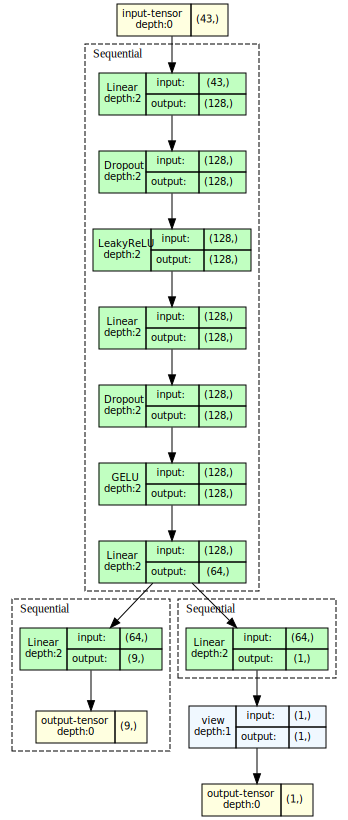

In [94]:
# Посмотрим какая модель у нас получилась
from torchview import draw_graph

model_graph = draw_graph(model, input_size=[cfg.num_features], expand_nested=True)
model_graph.visual_graph

Обучим нашим тренером

In [95]:
trainer = Trainer(
    accelerator='gpu',
    devices=cfg.device_count,
    max_epochs=cfg.epochs, # Устанавливаем кол-во эпох
    log_every_n_steps=10, # Как часто логируем метрики
    check_val_every_n_epoch=2, # Запускаем проверку val-части каждые 2 эпохи

    callbacks=[
        EarlyStopping( # Подключаем EarlyStopping
            monitor='valid/loss', # Какую метрику отлавливаем
            patience=3, # Сколько эпох валидации внимательно наблюдаем
            verbose=True, # Вывод как улучшается ил ухудшается метрика
        ),
        ModelCheckpoint( # Сохранение нескольких весов модели
            monitor='valid/loss',
            dirpath=f"../models/{cfg.model_name}", # Сохранение модели
            enable_version_counter=True, # Не затираем старые веса!
            # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
            save_top_k=3 # Сохраняем 3 лучших модели
        ),
    ],
    val_check_interval=0.2 # Запускать valid проверку каждые 0.2*epochs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [96]:
trainer.fit(model, datamodule=dataset)

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /app/storage_local/Course/ml_instruments/models/Lightning ⚡️ Improved exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                     | Type                | Params | Mode 
-------------------------------------------------------------------------
0 | mlp                      | Sequential          | 30.4 K | train
1 | regressor                | Sequential          | 65     | train
2 | classifier               | Sequential          | 585    | train
3 | regression_criterion     | MSELoss             | 0      | train
4 | classification_criterion | CrossEntropyLoss    | 0      | train
5 | train_metric_reg         | MeanAbsoluteError   | 0      | train
6 | train_metric_cls         | MulticlassHingeLoss | 0      | train
7 | valid_metric_reg         | MeanAbsoluteError   | 0      | train
8 | valid_metric_cls    

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: |                                                                                                 …

Metric valid/loss improved. New best score: 1.578


Validation: |                                                                                                 …

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 1.573


Validation: |                                                                                                 …

Metric valid/loss improved by 0.007 >= min_delta = 0.0. New best score: 1.565


Validation: |                                                                                                 …

Metric valid/loss improved by 0.007 >= min_delta = 0.0. New best score: 1.558


Validation: |                                                                                                 …

Metric valid/loss improved by 0.007 >= min_delta = 0.0. New best score: 1.551


Validation: |                                                                                                 …

Metric valid/loss improved by 0.037 >= min_delta = 0.0. New best score: 1.514


Validation: |                                                                                                 …

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 1.509


Validation: |                                                                                                 …

Metric valid/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.504


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 1.504


Validation: |                                                                                                 …

Metric valid/loss improved by 0.019 >= min_delta = 0.0. New best score: 1.485


Validation: |                                                                                                 …

Metric valid/loss improved by 0.004 >= min_delta = 0.0. New best score: 1.481


Validation: |                                                                                                 …

Metric valid/loss improved by 0.007 >= min_delta = 0.0. New best score: 1.474


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.013 >= min_delta = 0.0. New best score: 1.461


Validation: |                                                                                                 …

Metric valid/loss improved by 0.075 >= min_delta = 0.0. New best score: 1.385


Validation: |                                                                                                 …

Metric valid/loss improved by 0.010 >= min_delta = 0.0. New best score: 1.375


Validation: |                                                                                                 …

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 1.375


Validation: |                                                                                                 …

Metric valid/loss improved by 0.009 >= min_delta = 0.0. New best score: 1.366


Validation: |                                                                                                 …

Metric valid/loss improved by 0.008 >= min_delta = 0.0. New best score: 1.359


Validation: |                                                                                                 …

Metric valid/loss improved by 0.023 >= min_delta = 0.0. New best score: 1.336


Validation: |                                                                                                 …

Metric valid/loss improved by 0.011 >= min_delta = 0.0. New best score: 1.325


Validation: |                                                                                                 …

Metric valid/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.319


Validation: |                                                                                                 …

Metric valid/loss improved by 0.008 >= min_delta = 0.0. New best score: 1.312


Validation: |                                                                                                 …

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 1.306


Validation: |                                                                                                 …

Metric valid/loss improved by 0.024 >= min_delta = 0.0. New best score: 1.282


Validation: |                                                                                                 …

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.280


Validation: |                                                                                                 …

Metric valid/loss improved by 0.011 >= min_delta = 0.0. New best score: 1.269


Validation: |                                                                                                 …

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 1.266


Validation: |                                                                                                 …

Metric valid/loss improved by 0.015 >= min_delta = 0.0. New best score: 1.250


Validation: |                                                                                                 …

Metric valid/loss improved by 0.032 >= min_delta = 0.0. New best score: 1.218


Validation: |                                                                                                 …

Metric valid/loss improved by 0.008 >= min_delta = 0.0. New best score: 1.211


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 1.210


Validation: |                                                                                                 …

Metric valid/loss improved by 0.009 >= min_delta = 0.0. New best score: 1.201


Validation: |                                                                                                 …

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 1.200


Validation: |                                                                                                 …

Metric valid/loss improved by 0.008 >= min_delta = 0.0. New best score: 1.192


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.186


Validation: |                                                                                                 …

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 1.181


Validation: |                                                                                                 …

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 1.180


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 1.179


Validation: |                                                                                                 …

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.177


Validation: |                                                                                                 …

Metric valid/loss improved by 0.004 >= min_delta = 0.0. New best score: 1.174


Validation: |                                                                                                 …

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 1.173


Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


# Tuner

<div class="alert alert-info">

Что если вы не хотите подбирать начальный `learning rate`, чтобы моделька хорошо обучалась или же подбирать `batch size`, дабы влезло в `GPU`. В `Lightning` есть модуль `Tuner`, который позволяет подбирать эти параметры в автоматическом режиме

Давайте посмотрим как его использовать! 


In [97]:
model = SuperPuperModel(cfg)
trainer = Trainer(
    accelerator='gpu',
    devices=cfg.device_count,
    max_epochs=cfg.epochs, # Устанавливаем кол-во эпох
    callbacks=[
        EarlyStopping( # Подключаем EarlyStopping
            monitor='valid/loss', # Какую метрику отлавливаем
            patience=3, # Сколько эпох валидации внимательно наблюдаем
            verbose=True, # Вывод как улучшается ил ухудшается метрика
        ),
        ModelCheckpoint( # Сохранение нескольких весов модели
            monitor='valid/loss',
            dirpath=f"../models/{cfg.model_name}", # Сохранение модели
            enable_version_counter=True, # Не затираем старые веса!
            # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
            save_top_k=3 # Сохраняем 3 лучших модели
        ),
    ],
    val_check_interval=0.2 # Запускать valid проверку каждые 0.2*epochs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [98]:
tuner = pl.tuner.Tuner(trainer)

In [99]:
lr_finder = tuner.lr_find(model, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at /app/storage_local/Course/ml_instruments/notebooks/.lr_find_d6e0812e-bab0-42f6-84e7-10814abe9bc6.ckpt
Restored all states from the checkpoint at /app/storage_local/Course/ml_instruments/notebooks/.lr_find_d6e0812e-bab0-42f6-84e7-10814abe9bc6.ckpt


In [100]:
lr_finder.suggestion()

0.02089296130854041

<div class="alert alert-success">

`Lightning` нашел нам оптимальный learning rate буквально в 2 строчки кода! Как же прекрасен этот инструмент 🤗

Давайте посмотрим как находить `batch size` 

In [101]:
model = SuperPuperModel(cfg)
trainer = Trainer(
    accelerator='gpu',
    devices=cfg.device_count,
    max_epochs=cfg.epochs, # Устанавливаем кол-во эпох
    callbacks=[
        EarlyStopping( # Подключаем EarlyStopping
            monitor='valid/loss', # Какую метрику отлавливаем
            patience=3, # Сколько эпох валидации внимательно наблюдаем
            verbose=True, # Вывод как улучшается ил ухудшается метрика
        ),
        ModelCheckpoint( # Сохранение нескольких весов модели
            monitor='valid/loss',
            dirpath=f"../models/{cfg.model_name}", # Сохранение модели
            enable_version_counter=True, # Не затираем старые веса!
            # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
            save_top_k=3 # Сохраняем 3 лучших модели
        ),
    ],
    val_check_interval=0.2 # Запускать valid проверку каждые 0.2*epochs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Ищем batch_size для train части и для valid части 
bs_finder_train = tuner.scale_batch_size(model, datamodule=dataset, method='fit')
bs_finder_valid = tuner.scale_batch_size(model, datamodule=dataset, method='validate')

/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /app/storage_local/Course/ml_instruments/models/Lightning ⚡️ Improved exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
The batch size 2048 is greater or equal than the length of your dataset.
/app/storage_local/Course/ml_instruments/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None

`Trainer.fit` stopped: `max_steps=3` reached.
The batch size 2048 is greater or equal than the length of your dataset.
Finished batch size finder, will continue with full run using batch size 2048
Restoring states from the checkpoint path at /app/storage_local/Course/ml_instruments/notebooks/.scale_batch_size_64de7a33-8b97-4f8d-9456-86230477f57e.ckpt
Restored all states from the checkpoint at /app/storage_local/Course/ml_instruments/notebooks/.scale_batch_size_64de7a33-8b97-4f8d-9456-86230477f57e.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
The batch size 2048 is greater or equal than the length of your dataset.
The batch size 2048 is greater or equal than the length of your dataset.
Finished batch size finder, will continue with full run using batch size 2048
Restoring states from the checkpoint path at /app/storage_local/Course/ml_instruments/notebooks/.scale_batch_size_63815122-36d6-4b5c-9f41-82d82d2e4736.ckpt
Loaded model weights from the checkpoint at /app/storage_local/Course

In [106]:
bs_finder_train, bs_finder_valid

(2048, 2048)

# Итоги

В Этом уроке мы научились:
- Обучать нейронки с помощью `Trainer`. Он помогает вам сконцентрироваться на логике модели, а не на ее обучении
- Какие есть фишки в `Trainer` и что такие `callbacks`
- `Torchmetrics` - альтернатива метрикам из `torch.nn`
- Как `Torchmetrics` и `Lightning` клеятся вместе для удобной работы 🤗